# Pattern Task

## Hypothesis
Convolutional neural networks learn to separate noisy images from structured images with less training examples than fully connected neural networks.

## Measurement

We will measure the gap between the two models in the number of training examples required to exceed an accuracy of $\epsilon$ as a function of the side length $L$ of the image.

## Training Data

Generating the labels in $\{0, 1\}$:
+ $Y\sim \text{Bernoulli}(p)$ with parameter $p=0.5$.

Generating one image : 
+ Create Fourier-domain square image $\dot{X}$ of side length $L$. 

+ In a low pass box of side-length $L/2$, set between $1$ and $K\leq (L/2)^2$ random points to a random number on the complex unit circle, leaving the rest with amplitude $0$.

+ Then $|IFT(\dot{X})|$ with pixel-wise modulus corresponds to images with regular wave patterns, such as stripes or checkerboards.

+ We standardize $|IFT(\dot{X})|$ such that the average pixel value is 0 and variance of pixel values is 1, and call it $M$.

+ If the label is $1$, obfuscate $M$ with Gaussian noise sampled independently at every pixel $Z\sim \mathcal{N}(0, 1)$:
$$X = M + YZ$$

In [1]:
# Imports
import os
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from itertools import product
from helpers import *
from models import ModelLoader

### Settings
There are multiple variables associated with this experiment.
+ The range of image sizes to test 
    + We test $L\in[10, 25]$
+ The model architectures
    + Convolutional neural network (CNN)
        + Convolutional layer : $1$ in channel, $100$ out channels, kernel size $3$, stride $1$, padding $1$
        + Activation layer : ReLU
        + Max pool layer : kernel size $2$, stride $2$
        + Linear layer : _ in, $1$ out neuron
        + Sigmoid layer
    + Fully connected neural network (FCNN)
        + Linear layer : $L^2$ in, $P$ out neurons
        + Activation layer : ReLU
        + Linear layer : $P$ in, $1$ out neuron
        + Sigmoid layer
            + The first linear layer has $PL^2$ weights, the second has $P$ weights. So the FCNN has about $P(L^2+1)$ parameters.
            + We set $P$ so that the FCNN matches the CNN in terms of raw parameter count. 
            + If the CNN has $Q$ parameters, then let $P=\max\{1, Q / (L^2+1)\}$
+ The learning protocol
    + Stochastic Gradient Descent 
    + Batch-size $64$
    + Accuracy goal $\epsilon \in \{0.95\}$
    + Learning rate $0.01$
    + Set a training loss goal to $0.5$
        + 
        + lower it every time the model fails the test accuracy requirement.
    
        
    + Stop when $\alpha > \epsilon$.
        + Note - no notion of epoch. The model looks at fresh examples until it can generalize.
+ Distinct frequency count $\leq K=8$

In [33]:
# Experiment variables
min_w           = 20 # Minimum image width
max_w           = 21 # Maximum image width
skip_w          = 1 # Skip widths
delete          = True # Delete results of previous runs for that model.
relative        = True # The bo
architecture    = "CNN" 
activation      = "ReLU"
arch_name       = architecture + "+" + activation
learning_rate   = 0.01
cnn_out_chans   = 500
batch_size      = 32
N_tr            = 25_000   # Training set
N_te            = 10_000   # Test set
epsilon         = 0.8     # Required accuracy
freq            = 8       # Max number of distinct frequencies            
clamp           = 8       # Frequency band clamp
filepath        = 'results/week8/acc'+str(int(epsilon * 100))+('rel' if relative else 'freq'+str(freq)+'clamp'+str(clamp))+'.pkl' # Results file

In [34]:
# Create file if it doesn't exist
with open(filepath, 'ab+') as file:
    if os.stat(filepath).st_size == 0:
        pickle.dump(dict(), file)

# Option del - delete contents of results file
if delete:
    with open(filepath, 'rb+') as file:
        results = pickle.load(file)

    # Filter out results with same name
    with open(filepath, 'wb+') as file:
        filtered = {(name, size) : val for (name, size), val in results.items() if name!=arch_name}
        pickle.dump(filtered, file)

In [35]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, "\n")

# Don't try to use CuDNN with Tesla GPU
torch.backends.cudnn.enabled = False

# GPU has not a lot of memory, so empty cache
torch.cuda.empty_cache() 

# Avoid fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256" 

Using device:  cpu 



In [36]:
def gen_pattern_xy(width, channels, number, max_freq, clamp):

    # Choose a number of frequencies
    freqs = np.arange(1, max_freq+1)
    freq = np.random.choice(a=freqs, p=freqs / np.sum(freqs))

    # Bernoulli labels : noise / no noise
    sigs = np.random.choice([0, 1], size=(number, ), p=[0.5, 0.5])
    y = np.where(sigs == 0, 0, 1)

    # Blank F-domain canvases [number, channels, width, height]
    blank = np.zeros(width * width).astype(complex)
    f_dom = blank.reshape((1,len(blank))).repeat(number, axis=0).reshape((number, channels, width, width))

    # Select random pixels in low frequency box
    span = np.arange(-clamp//2, clamp//2+1)         # Index [-clamp, clamp] along one dimension
    w, h = list(zip(*list(product(span, span))))    # The pairs of indices in two dimensions unzipped
    subarray = f_dom[..., w, h]                
    subarray[..., :freq] = np.exp(2 * np.pi * 1j * np.random.rand(number, channels, freq)) # Set some capped number of pixels to 1 in the box
    permute_along_axes(subarray, [2])               # Randomize the position of those pixels 
    f_dom[..., w, h] = subarray                     # Assign the original image with those pixels

    # Perform the 2D inverse Fourier transform
    x_dom = np.array([standardize(img) for img in np.abs(np.fft.ifft2(f_dom))])

    # Add noise depending on the label
    x_dom = np.array([x_dom[j] + np.random.normal(0, sigs[j], size=(channels, width, width)) for j in range(number)])

    # Convert to torch tensors
    x_dom = torch.from_numpy(x_dom).to(torch.float32)
    y = torch.from_numpy(y.reshape((-1,1))).to(torch.float32)

    # L1-normalize the image
    #x_dom /= x_dom.norm(p=1, dim=[2,3], keepdim=True)

    return x_dom, y, f_dom

In [37]:
# Reset number generation
np.random.seed(0)
torch.manual_seed(0)

# Model loader
loader = ModelLoader()

# Input shape
channels = 1
img_sides = np.arange(min_w, max_w+1, skip_w) # Image side lengths
input_dims = channels*img_sides**2 # Input dimension
input_shapes = [(channels, img_size, img_size) for img_size in img_sides]

# Create dataset images
for i, l in enumerate(img_sides):

    # Print progress
    print(f"Image width: {l}")

    # Generate dataset and dataloaders
    print(f"Generating data")
    clamp_ = l//2 if relative else clamp
    x_tr, y_tr, _ = gen_pattern_xy(l, channels, N_tr, freq, clamp_)
    x_te, y_te, _ = gen_pattern_xy(l, channels, N_te, freq, clamp_)
    
    tr_loader = DataLoader(TensorDataset(x_tr, y_tr), batch_size=batch_size, shuffle=True)
    te_loader = DataLoader(TensorDataset(x_te, y_te), batch_size=batch_size, shuffle=True)

    # Load model
    
    model_options = {'input_shape': input_shapes[i], 'out_channels': cnn_out_chans}

    # Parameter-fair FCNN options
    if architecture == "FCNN":
        
        # Create reference CNN
        cnn = loader.load("CNN", "ReLU", {'input_shape': input_shapes[i], 'out_channels': cnn_out_chans})
        cnn_param_count = sum(p.numel() for p in cnn.parameters())
        hidden_neurons = max(1, int(cnn_param_count / (input_dims[i]+1)))
        print("Number of hidden_neurons", hidden_neurons)
        # Set number of hidden neurons to match CNN
        model_options['hidden_neurons'] = hidden_neurons

    model = loader.load(architecture, activation, model_options).to(device)

    # Print number of parameters
    print("Generated", architecture, "with", count_parameters(model), "parameters")
    
    # Optimizer and criterion
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # Training loop
    model.train()
    tr_loss_req = 0.5
    tr_step = 0
    for batch_x, batch_y in tr_loader:
        model.train()
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        tr_loss = criterion(output, batch_y)
        tr_loss.backward()
        optimizer.step()
        print(tr_loss.item())

        # Evaluate (when tr_loss is small)
    accuracy = 0.0
     
    if tr_loss.item() < tr_loss_req:
        with torch.no_grad():
            model.eval()
            for batch_x, batch_y in te_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output = model(batch_x)
                accuracy += sum(torch.eq((output>0.5).to(float), batch_y)).item()
            accuracy /= N_te
        print(accuracy)
        tr_loss_req = max(0.01, tr_loss_req - 0.05)
        
    # Check goal
    tr_step += 1
    if accuracy > epsilon:
        print(f"Reached accuracy: {accuracy} in {tr_step} batches of size {batch_size}.")
        break

    # Save results
    with open(filepath, 'rb') as file:
        results = pickle.load(file)

    # Add experiment to results
    results[(arch_name, input_dims[i])] = tr_step * batch_size

    # Write training set size to file
    with open(filepath, 'wb') as file:
        pickle.dump(results, file)
        
    # Print progress
    print(f"Progress: {i +1} / {(max_w - min_w) // skip_w + 1}")

Image width: 20
Generating data


Generated CNN with 55001 parameters
0.6454837322235107
62.5
36.269813537597656
1.2029253244400024
40.446224212646484
37.34122085571289
39.965919494628906
37.67832565307617
35.22665023803711
28.576858520507812
39.71037292480469
37.31487274169922
39.78012466430664
34.955108642578125
31.047775268554688
44.345706939697266
32.566062927246094
44.238746643066406
47.06516647338867
33.01142501831055
30.160707473754883
44.519874572753906
39.96957015991211
37.31696319580078
29.91016387939453
29.976348876953125
32.123619079589844
30.402130126953125
42.515625
46.40220260620117
33.13501739501953
37.516822814941406
32.9437370300293
25.6291446685791
37.380828857421875
39.65305709838867
37.326019287109375
20.962177276611328
43.15633010864258
39.69591522216797
38.192543029785156
37.59832000732422
49.547218322753906
34.268043518066406
36.924495697021484
34.69395065307617
35.32174301147461
34.796714782714844
39.30992126464844
39.908382415771484
28.28614044189453
37.803829193115234
44.303836822509766
35.13

KeyboardInterrupt: 

When number of filters $100$, the FCNN matches

|Image size | CNN params | FCNN params |
|-----------|:------------:|:-------------:|
| 10 | 3501 | 3469 |
| 11 | 3501 | 3445 |
| 12 | 4601 | 4527 |
| 13 | 4601 | 4618 |
| 14 | 5901 | 5743 |
| 15 | 5901 | 5903 |

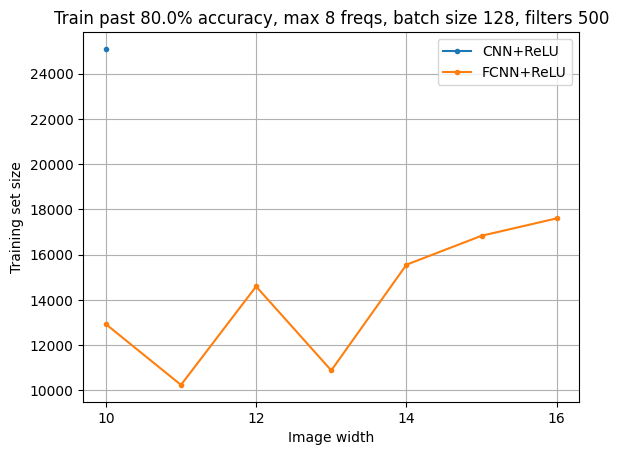

In [27]:
# Load data
with open(filepath, 'rb') as file:
    sample_complexity = pickle.load(file)
# Extract data to plot
names = set([name for name, _ in sample_complexity.keys()])

# For every model, make line plot
for i, name in enumerate(names):
    x, y = list(zip(*sorted([(int((dim)**0.5), tr_size) for (_name, dim), tr_size  in sample_complexity.items() if name == _name])))
    plt.plot(x, y, marker='.', linestyle='-', label=name)

# Plot graphics
plt.xlabel('Image width')
plt.ylabel('Training set size')
plt.xticks(ticks=[tick for tick in plt.xticks()[0]][1::2], labels=[tick for tick in plt.xticks()[1]][1::2])
plt.title(f'Train past {epsilon*100}% accuracy, max {freq} freqs, batch size {batch_size}, filters {cnn_out_chans}')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()